In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
import warnings
warnings.filterwarnings("ignore")
import sys
import subprocess

In [3]:
data = pd.read_csv('data.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.columns.tolist()

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [6]:
data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [7]:
target_candidates = ['charges', 'age' , 'children','bmi','sex','smoker','region']
target_col = None
for col in target_candidates:
    if col.lower() in target_candidates:
        target_col = col
        break
if target_col is None:
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        target_col = numeric_cols[-1]
    else:
        target_col = data.columns[-1]
print(f"Selected target column: {target_col}")

Selected target column: charges


In [8]:
for col in target_candidates:
    data[col] = LabelEncoder().fit_transform(data[col])

Text(0.5, 1.0, 'Distribution of charges')

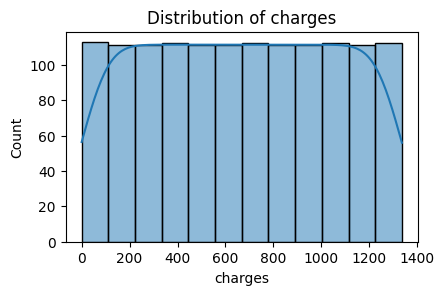

In [9]:
plt.figure(figsize = (10,6))
plt.subplot(2,2,1)
sns.histplot(data[target_col], kde=True)
plt.title(f"Distribution of {target_col}")

Text(0.5, 1.0, 'BMI vs Charges')

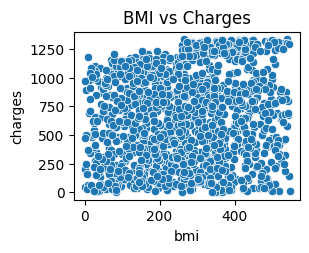

In [10]:
plt.subplot(2,2,2)
sns.scatterplot(x='bmi', y='charges', data=data)
plt.title('BMI vs Charges')

Text(0.5, 1.0, ' Age vs Charges')

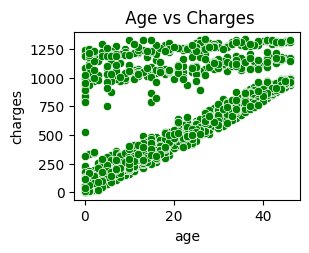

In [11]:
plt.subplot(2,2,3)
sns.scatterplot(x='age',y='charges',data = data, color='green')
plt.title(' Age vs Charges')

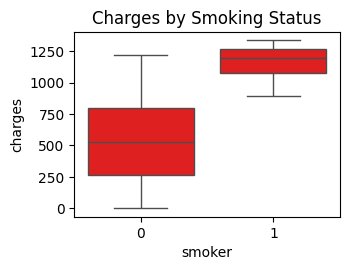

In [12]:
plt.subplot(2,2,3)
sns.boxplot(x='smoker', y='charges', data=data, color='red')
plt.title('Charges by Smoking Status')
plt.tight_layout()
plt.show()

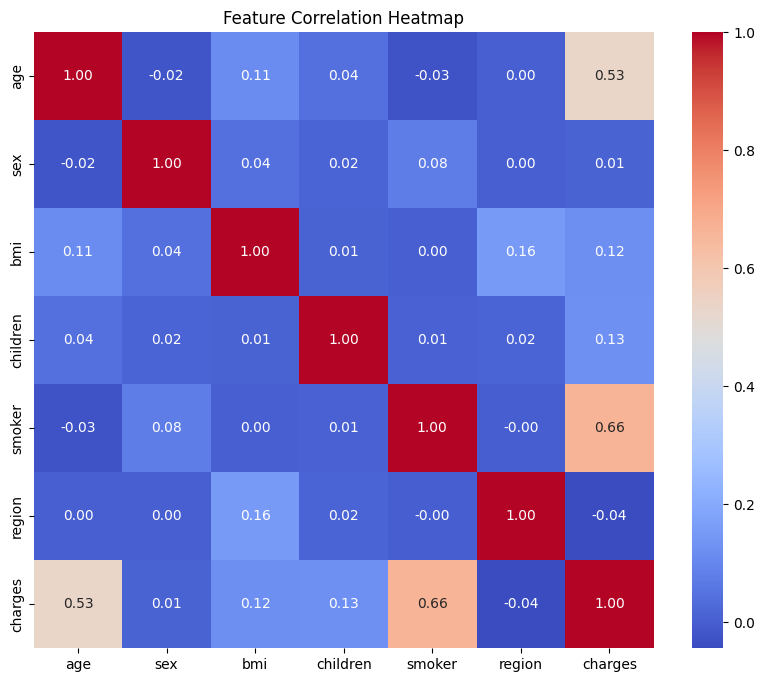

In [13]:
corr = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [14]:
X = data.drop(columns=[target_col])
y = data[target_col]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown= 'ignore'))
])
preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)
task_type = "regression" if pd.api.types.is_numeric_dtype(y) and y.nunique() > 10 else "classification"
print("Detected task type:", task_type)

Detected task type: regression


In [15]:
X_test,X_train,y_test,y_train = train_test_split(X,y,test_size=0.2, random_state=42)
if task_type == "regression":
    model = LinearRegression()
else:
    model = LogisticRegression(max_iter=200)
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])
print("Training the model..")
pipeline.fit(X_train, y_train)
print("Model training completed.")

Training the model..
Model training completed.


In [16]:
y_pred = pipeline.predict(X_test)
if task_type == "regression":
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R2 score: {r2}")
else:
    accuracy_score = accuracy_score(y_test,y_pred)
    print(f"Accuracy Score: {accuracy_score}")
    joblib.dump(pipeline, 'model_pipeline.pkl')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Mean Squared Error: 37924.49447390801
R2 score: 0.7414910959390538


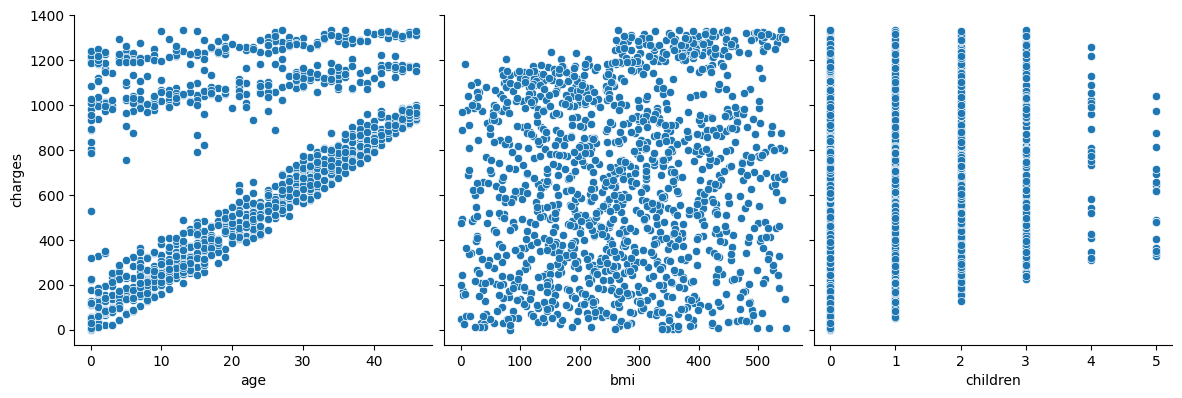

In [17]:
os.makedirs('models', exist_ok = True)
sns.pairplot(data, x_vars=['age', 'bmi', 'children'], y_vars = [target_col], height=4, aspect=1, kind='scatter')

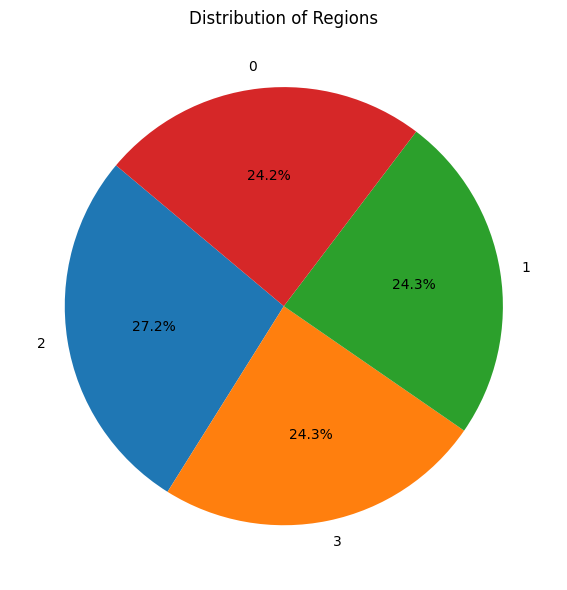

In [18]:
region_counts = data['region'].value_counts()
plt.figure(figsize=(10,6))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Regions')
plt.tight_layout()
plt.show()

In [30]:
import dash
from dash import dcc, html
import plotly.express as px
from dash.dependencies import Input, Output
app = dash.Dash(__name__)
pie_fig = px.pie(names=region_counts.index, values=region_counts.values, title='Distribution of Regions')
bar_fig = px.bar(data, x='region', y=target_col, color='smoker', barmode='group', title=f'{target_col} by Region and Smoking Status')
violin_fig = px.violin(data, y=target_col, x='smoker', color='smoker', box=True, points='all', title=f'{target_col} Distribution by Smoking Status')
corr = data.corr()
corr_fig = px.imshow(corr, text_auto=True, aspect="auto", title='Feature Correlation Heatmap')
scatter_fig = px.scatter(data, x=['bmi','age','children','charges'], y=target_col, color='smoker', title=f'BMI vs {target_col} by Smoking Status')
"""
app.layout = html.Div([
    html.H1('Insurance Data Interactive Dashboard'),
    html.Div([
        dcc.Graph(figure=pie_fig),
        dcc.Graph(figure=bar_fig),
        dcc.Graph(figure=violin_fig)
    ], style={'display': 'flex', 'flex-direction': 'row', 'justify-content': 'space-between'}),
    dcc.Graph(figure=corr_fig),
    dcc.Graph(figure=scatter_fig)
])
"""
app.layout = html.Div([
    html.H1(
    'Insurance Data Interactive Dashboard',
    style={'color': 'green'}
),
    html.Div([
        html.Label('Select Region:'),
        dcc.Dropdown(
            options=[{'label': r, 'value': r} for r in data['region'].unique()],
            value=data['region'].unique()[0], id='region-dropdown')
    ], style={'width': '30%', 'display': 'inline-block'}),
    dcc.Graph(id='charges-bmi'),
    dcc.Graph(figure=corr_fig),
    dcc.Graph(figure=scatter_fig),
    dcc.Graph(figure=pie_fig),
    dcc.Graph(figure=bar_fig),
    dcc.Graph(figure=violin_fig)
])
@app.callback(
    Output('charges-bmi', 'figure'),
    [Input('region-dropdown', 'value')]
)
def update_bmi_scatter(region):
    # Defensive: If no region selected, show all data
    if region is None or region not in data['region'].unique():
        filtered = data
        subtitle = "(All Regions)"
    else:
        filtered = data[data['region'] == region]
        subtitle = f"({region})"
    fig = px.scatter(filtered, x='bmi', y='charges', color='smoker',
                     title=f'BMI vs Charges {subtitle}',
                     labels={'charges': 'Charges', 'bmi': 'BMI'},
                     hover_data=['age', 'children'])
    fig.update_traces(marker=dict(size=10, opacity=0.7))
    fig.update_layout(transition_duration=400)
    return fig
if __name__ == '__main__':
    app.run(debug=True)